In [72]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gseapy as gsp
import seaborn as sns
import glob
from functools import partial
import re

In [3]:
#gene_sets = {gene_set: pd.read_excel('../data/Gene pool_H7N9.xls', sheet_name=gene_set) for gene_set in ['Set 1', 'Set 2']}
#gene_sets['Set 1'].head()
tables = glob.glob('../data/*tsv')
gene_sets = {tab:pd.read_table(tab, names = ['GeneID','GeneDescription']) for tab in tables}
gene_sets[tables[0]].head()

,GeneID,GeneDescription
0,CD177,CD177 molecule
1,MGAM2,maltase-glucoamylase 2 (putative)
2,B4GALT5,"UDP-Gal:betaGlcNAc beta 1,4- galactosyltransfe..."
3,RNASE2,"ribonuclease, RNase A family, 2 (liver, eosino..."
4,PADI4,"peptidyl arginine deiminase, type IV"


In [4]:
enrichments = {}
for key, gs_df in gene_sets.items():
#    gs_df = gs_df.sort_values('per OI')
    enrichment = gsp.enrichr(gene_list = gs_df.GeneID.tolist(),
                    gene_sets = 'KEGG_2016',
                    outdir='../Enrichr' ,format='png') 
    enrichments[key] = enrichment

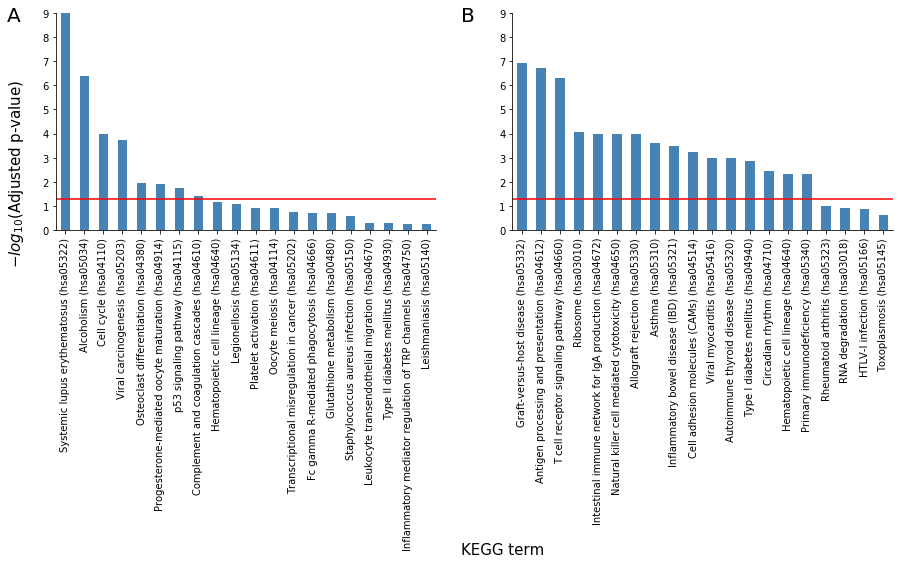

In [5]:
fig = plt.figure(figsize = (15,4))
for i, (gene_set, enr) in enumerate(enrichments.items()):
    ax = fig.add_subplot(1, 2, i + 1)
    enr.res2d\
        .reset_index()\
        .nsmallest(20,'Adjusted P-value')\
        .assign(log_p = lambda d: d['Adjusted P-value'].transform(lambda x: -np.log10(x)))\
        .assign(Term = lambda d: d.Term.str.replace('_Homo sapiens_',' (') + ')')\
        .plot.bar('Term','log_p', ax = ax, 
              color = 'steelblue')
    ax.hlines(xmin = -1, xmax = 100, y = -np.log10(0.05), color = 'red')
    #ax.set_title(gene_set)
    ax.set_ylim(0,9)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    ax.legend().set_visible(False)
sns.despine()
fig.text(0.08, 0.6, r'$-log_{10}$(Adjusted p-value)', size = 15, rotation= 90)
fig.text(0.5, -1, 'KEGG term', size = 15)
fig.text(.08,0.85,'A', size = 20)
fig.text(0.5,.85, 'B', size = 20)
figurename = '../figures/kegg_enrichment.png'
fig.savefig(figurename, bbox_inches='tight', transparent = True, dpi = 250)

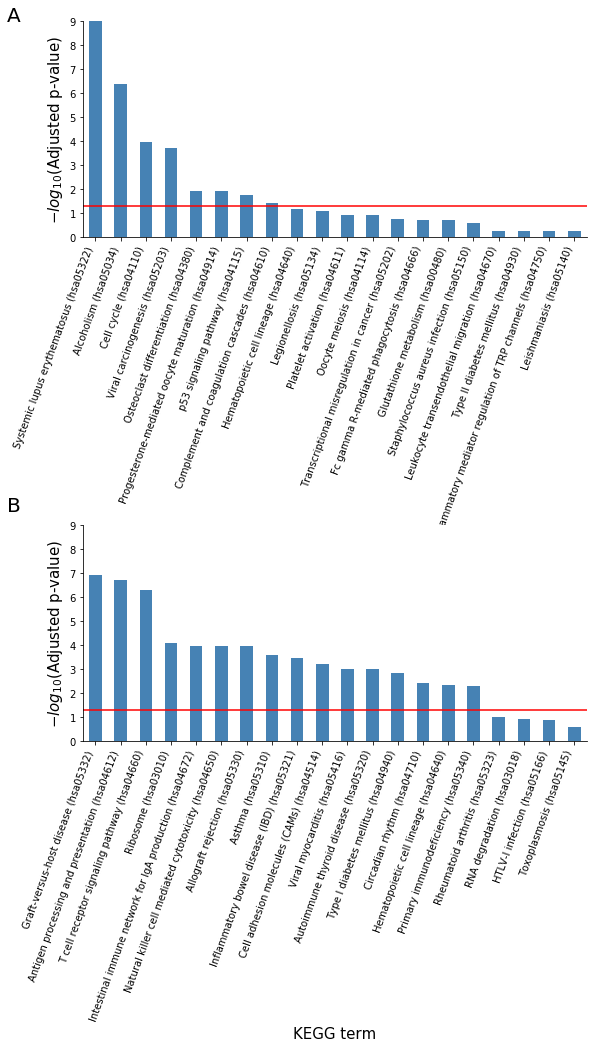

In [6]:
fig = plt.figure(figsize = (7,10))
axes = [[0, 0.7, 1, 0.3],
       [0, 0, 1, 0.3]]
for i, (gene_set, enr) in enumerate(enrichments.items()):
    ax = fig.add_axes(axes[i])
    enr.res2d\
        .reset_index()\
        .nsmallest(20,'Adjusted P-value')\
        .assign(log_p = lambda d: d['Adjusted P-value'].transform(lambda x: -np.log10(x)))\
        .assign(Term = lambda d: d.Term.str.replace('_Homo sapiens_',' (') + ')')\
        .plot.bar('Term','log_p', ax = ax, 
              color = 'steelblue')
    ax.hlines(xmin = -1, xmax = 100, y = -np.log10(0.05), color = 'red')
    #ax.set_title(gene_set)
    ax.set_ylim(0,9)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right')
    ax.set_ylabel(r'$-log_{10}$(Adjusted p-value)', size = 15)
    if i == 1:
        ax.set_xlabel('KEGG term', size = 15)
    else:
        ax.set_xlabel(' ')
    ax.legend().set_visible(False)
sns.despine()
fig.text(-0.15,1,'A', size = 20)
fig.text(-0.15,0.32, 'B', size = 20)
figurename = '../figures/kegg_enrichment.png'
fig.savefig(figurename, bbox_inches='tight', transparent = True, dpi = 250)

In [7]:
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas

In [61]:
pathway_ids = ['hsa04660', #T cell
            'hsa04650', #NK cells
            'hsa04110', #cell cycle
            'hsa04115', #p53
            'hsa04380', #osteo
            'hsa05322' ] #SLE
set_origins = [tables[1], 
               tables[1], 
               tables[0], 
               tables[0], 
               tables[0]]
enriched_color = '#FFB600' #oragne
non_enriched_color = '#FFFFFF' #white
text_color = '#000000' #black

In [79]:
def matched_gene(gene_regex, gene_names):
    matched = re.search('(' + gene_regex + ')', gene_names)
    if matched:
        return matched.group(0)

def plot_pathway(enrichments, set_origin, pathway_id):
    enriched_genes = enrichments[set_origin]\
        .res2d \
        .pipe(lambda d: d[d.Term.str.contains(pathway_id)]) \
        .iloc[0, -1]\
        .split(';')
    print('[%s] Enriched genes: %s' %(pathway_id,', '.join(enriched_genes)))
    match_re = '|'.join([gene[:4] for gene in enriched_genes])


    #grep pathway
    pathway = KGML_parser.read(kegg_get(pathway_id, "kgml"))
    
    # change color for pathway elements
    for entry in pathway.entries.values():
        matched = matched_gene(match_re, entry.graphics[0].name)
        if matched:
            entry.graphics[0].bgcolor = enriched_color
            entry.graphics[0].fgcolor = text_color
            #entry.graphics[0].name = matched
        elif pathway_id == "hsa05322" and any([i in entry.graphics[0].name for i in ['HIST1H','HIST2H','FCGR','ACTN']]):
            '''
            histone gene mapping
            '''
            entry.graphics[0].bgcolor = enriched_color
            entry.graphics[0].fgcolor = text_color        
        else:
            entry.graphics[0].bgcolor = non_enriched_color
            entry.graphics[0].fgcolor = text_color
        entry.graphics[0].name = entry.graphics[0].name.split(',')[0]
    
    pathway_figure = '../figures/%s.pdf' %pathway_id
    canvas = KGMLCanvas(pathway, import_imagemap=True, fontsize=10)
    canvas.draw(pathway_figure)
    print('Drawn: ', pathway_figure)
    return pathway

In [80]:
plot_func = partial(plot_pathway, enrichments)
pathways = list(map(plot_func, set_origins, pathway_ids))

[hsa04660] Enriched genes: ITK, CBLB, CD3G, PIK3R1, CD3E, RASGRP1, CD3D, MALT1, PPP3R1, PPP3CC, AKT3, CTLA4, FYN, PLCG1, ICOS, NFATC3, NFATC2, ZAP70, CD4, DLG1, CD40LG, CD8B, CD8A, LCK, CD28, PRKCQ, CD247, MAP3K14, CARD11, LAT
Drawn:  ../figures/hsa04660.pdf
[hsa04650] Enriched genes: PRF1, PIK3R1, KIR2DL1, KIR2DL2, ITGAL, KIR2DL3, PPP3R1, PPP3CC, FYN, KLRC1, PLCG1, KIR2DS1, KLRC2, KLRC3, SH2D1A, KIR2DS4, SH2D1B, KIR2DS5, TNFRSF10B, NFATC2, GZMB, KIR3DL2, NCR1, ZAP70, LCK, KLRD1, CD48, CD247, CD244, LAT
Drawn:  ../figures/hsa04650.pdf
[hsa04110] Enriched genes: GADD45A, PLK1, TTK, CDC6, CDC25C, CDC25A, CDC20, CCNA2, CCNB1, CDC45, ESPL1, ORC1, CHEK1, CDK1, BUB1
Drawn:  ../figures/hsa04110.pdf
[hsa04115] Enriched genes: CCNB1, RRM2, GADD45A, CHEK1, CDK1, FAS, IGF1, GTSE1
Drawn:  ../figures/hsa04115.pdf
[hsa04380] Enriched genes: FOSL1, LILRA6, SOCS3, FCGR2A, IL1R1, NCF4, PLCG2, SIRPA, PPARG, MAPK14, LILRB3, LILRA5
Drawn:  ../figures/hsa04380.pdf


In [44]:
set_origin = '../data/GeneDes_OXY_Low_LRT_Up.tsv'
pathway_id = 'hsa05034'

enrichments[set_origin]\
        .res2d\
        .pipe(lambda d: d[d.Term.str.contains(pathway_id)]) \
        .iloc[0, -1]\
        .split(';')

['HIST1H2AM',
 'HDAC4',
 'HIST1H2AL',
 'HIST1H2BO',
 'HIST1H4L',
 'HIST1H2AH',
 'HIST1H2BI',
 'HIST1H2AJ',
 'HIST1H2BK',
 'HIST2H2BF',
 'HIST2H2BE',
 'HIST1H3A',
 'HIST1H3F',
 'HIST1H2BF',
 'HIST1H4H',
 'HIST1H2AD',
 'HIST1H3G',
 'HIST1H2BE',
 'HIST1H2BB',
 'HIST1H4D',
 'HIST1H2AC',
 'HIST1H2AB']

In [64]:
pathway_id = 'hsa04380'

enrichments[set_origin]\
        .res2d \
        .pipe(lambda d: d[d.Term.str.contains(pathway_id)]) \
        .iloc[0, -1]\
        .split(';')

['FOSL1',
 'LILRA6',
 'SOCS3',
 'FCGR2A',
 'IL1R1',
 'NCF4',
 'PLCG2',
 'SIRPA',
 'PPARG',
 'MAPK14',
 'LILRB3',
 'LILRA5']